In [1]:
%pip install -U pandas numpy scikit-learn joblib matplotlib seaborn
# In a new cell (e.g., cell [2])
# Install libraries required for the Deep Learning model
%pip install tensorflow scikeras


  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
ydata-profiling 0.0.dev0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.6 which is incompatible.
ydata-profiling 0.0.dev0 requires numba<=0.61,>=0.56.0, but you have numba 0.61.2 which is incompatible.
ydata-profiling 0.0.dev0 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.


  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)

  Attempting uninstall: protobuf

    Found existing installation: protobuf 5.29.5

    Uninstalling protobuf-5.29.5:

      Successfully uninstalled protobuf-5.29.5

   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
  Attempting uninstall: numpy
   ---------------------------------------- 0/2 [protobuf]
    Found existing installation: numpy 2.2.6
   ---------------------------------------- 0/2 [protobuf]
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [numpy]
    Uninstalling numpy-2.2.6:
   -------------------- ------------------- 1/2 [numpy]
   -------------------- ------------------- 1/2 [n

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydata-profiling 0.0.dev0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.6 which is incompatible.
ydata-profiling 0.0.dev0 requires numba<=0.61,>=0.56.0, but you have numba 0.61.2 which is incompatible.


In [2]:
# Imports and small helpers
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
from itertools import product

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# plotting & UI
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, clear_output

# ipywidgets for interactive input
import ipywidgets as widgets

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [3]:
import requests

def fetch_odisha_rainfall():
    """Fetch last year's rainfall from local FastAPI."""
    try:
        url = "http://127.0.0.1:8000/rainfall"  # FastAPI must be running!
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        print(f"Fetched rainfall for {data['year']}: {data['total_rainfall_mm']} mm")
        return float(data["total_rainfall_mm"])
    except Exception as e:
        print("Rainfall API error:", e)
        return None


In [4]:
BASE_DIR = os.path.abspath(".")  # absolute path of current folder
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(ARTIFACTS_DIR, "yield_model_pipeline.joblib")
RECS_SAVE_PATH = os.path.join(ARTIFACTS_DIR, "top_recommendations_sample.csv")

print("Absolute path of model:", MODEL_SAVE_PATH)
print("Absolute path of recommendations:", RECS_SAVE_PATH)




Absolute path of model: c:\Users\KIIT\Desktop\DEEP LEARN\artifacts\yield_model_pipeline.joblib
Absolute path of recommendations: c:\Users\KIIT\Desktop\DEEP LEARN\artifacts\top_recommendations_sample.csv


In [5]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# --- FIX: Define file paths before they are used ---
# This section should be at the top of your data loading script or in a preceding cell.
DATA_PATH = "sorted_data.csv"
WEATHER_PATH = os.path.join("artifacts", "fetched_weather.csv")
SOIL_PATH = os.path.join("artifacts", "fetched_soil.csv")


# --- Your data loading and cleaning code (now it will work) ---
# Load dataset and do safe cleaning
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please place your sorted_data.csv at this path or update DATA_PATH.")

df = pd.read_csv(DATA_PATH)

# --- OPTIONAL: merge fetched real-time weather & soil CSVs if present ---
if os.path.exists(WEATHER_PATH):
    fw = pd.read_csv(WEATHER_PATH)
    if {'lat','lon'}.issubset(df.columns) and {'lat','lon'}.issubset(fw.columns):
        df = df.merge(fw, on=['lat','lon'], how='left')
        print("Merged weather data from", WEATHER_PATH)
    else:
        print("Weather file found but lat/lon not present in main df — skip merge; use manual/API fetch at prediction time.")

if os.path.exists(SOIL_PATH):
    fs = pd.read_csv(SOIL_PATH)
    if {'lat','lon'}.issubset(df.columns) and {'lat','lon'}.issubset(fs.columns):
        df = df.merge(fs, on=['lat','lon'], how='left')
        print("Merged soil data from", SOIL_PATH)
    else:
        print("Soil file found but lat/lon not present in main df — skip merge; use manual/API fetch at prediction time.")

df.columns = df.columns.str.strip()  # strip whitespace on column names

# Ensure required columns exist or create placeholders
required_cols = ['Crop','Crop_Year','Season','State','Area','Production','Annual_Rainfall','Fertilizer','Pesticide','Yield']
for c in required_cols:
    if c not in df.columns:
        df[c] = np.nan

# Coerce numeric columns
num_cols = ['Area','Production','Annual_Rainfall','Fertilizer','Pesticide','Yield','Crop_Year']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# If Yield missing, compute Production/Area where possible
# Added a check to prevent division by zero or by NaN
df['Yield'] = df['Yield'].fillna(df['Production'] / df['Area'].replace(0, np.nan))


# Drop rows without a valid Yield or without Crop/State/Season
before = len(df)
df = df.dropna(subset=['Yield','Crop','State','Season'])
print(f"Loaded rows: {before} -> after dropping invalid rows: {len(df)}")

# Convert categorical columns to strings
for c in ['Crop','State','Season']:
    df[c] = df[c].astype(str)

# Quick peek
display(df.head(5))

Loaded rows: 1324 -> after dropping invalid rows: 1324


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arhar/Tur,1997,Autumn,Odisha,25621.0,6487.0,1496.6,2438350.57,7942.51,0.202778
1,Arhar/Tur,1997,Summer,Odisha,86559.0,16414.0,1496.6,8237820.03,26833.29,0.216786
2,Arhar/Tur,1997,Winter,Odisha,116553.0,23305.0,1496.6,11092349.01,36131.43,0.198929
3,Groundnut,1997,Autumn,Odisha,37462.0,34433.0,1496.6,3565258.54,11613.22,0.840435
4,Groundnut,1997,Summer,Odisha,39729.0,48815.0,1496.6,3781008.93,12315.99,1.211071


In [6]:
# --- FEATURES (include weather/soil placeholders) ---
FEATURES = [
    'Crop','Crop_Year','Season','State',
    'Area','Annual_Rainfall','Fertilizer','Pesticide',
    # 'group_avg_yield','group_avg_fertilizer','group_avg_pesticide','group_avg_rainfall',
    # Real-time / fetched features (may be NaN if not available)
    'Temp','Humidity','WindSpeed',                 # weather
    'Soil_Moisture','Soil_Temperature','Soil_pH','Soil_OrganicCarbon'  # soil
]

# create any missing feature columns as NaN so preprocessor has consistent column set
for f in FEATURES:
    if f not in df.columns:
        df[f] = np.nan


In [7]:
TARGET = 'Yield'
X = df[FEATURES].copy()
y = df[TARGET].copy()

# If you want to simulate future-year predictions, use time-split. For now use random split but prefer time-split later.
# Example to use time-split (recommended if you evaluate future years):
use_time_split = False
if use_time_split and 'Crop_Year' in df.columns:
    cutoff = int(df['Crop_Year'].quantile(0.85))
    train_mask = df['Crop_Year'] <= cutoff
    X_train, X_test = X[train_mask].copy(), X[~train_mask].copy()
    y_train, y_test = y[train_mask].copy(), y[~train_mask].copy()
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 1125 Test size: 199


In [8]:
categorical_features = ['Crop','Season','State']
numeric_features = [c for c in FEATURES if c not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Preprocessor ready with numeric features:", numeric_features)


Preprocessor ready with numeric features: ['Crop_Year', 'Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Temp', 'Humidity', 'WindSpeed', 'Soil_Moisture', 'Soil_Temperature', 'Soil_pH', 'Soil_OrganicCarbon']


In [21]:
# ===================================================================
# IMPORTS: All potential libraries should be imported at the top.
# ===================================================================
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor # Import XGBoost unconditionally

# --- ADDITIONS FOR DEEP LEARNING MODEL ---
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# --- END OF ADDITIONS ---


# --- ADDITIONS FOR DEEP LEARNING MODEL ---
# Function to create the Keras model, now with a required input shape parameter
def create_model(n_features_in, optimizer='adam', dropout_rate=0.2, hidden_layer_sizes=(64, 32)):
    """Builds and compiles a Keras Sequential model."""
    model = Sequential()
    
    # *** FIX: Define the input shape on the first layer ***
    model.add(Dense(hidden_layer_sizes[0], activation='relu', input_shape=(n_features_in,)))
    model.add(Dropout(dropout_rate))
    
    # Second hidden layer
    model.add(Dense(hidden_layer_sizes[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Output layer for regression (1 neuron, linear activation)
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    
    return model
# --- END OF ADDITIONS ---


# ===================================================================
# CONFIGURATION: Centralize model choices and parameters.
# ===================================================================

# --- FIX FOR KERAS MODEL BUILDING: Determine the input shape for the NN ---
# We fit the preprocessor on the training data to see how many features it will output.
# This is necessary to define the input layer of our neural network beforehand.
preprocessor.fit(X_train)
n_features = preprocessor.transform(X_train).shape[1]
print(f"INFO: Number of features after preprocessing: {n_features}")
# --- END OF FIX ---


# --- Choose model type: "rf" for RandomForest, "xgb" for XGBoost, "nn" for Neural Network ---
MODEL_CHOICE = "nn"  # Set to "nn" to train the new model

# --- Define models and their parameter grids in a configuration dictionary ---
model_configs = {
    "rf": {
        "model": RandomForestRegressor(random_state=42, n_jobs=1),
        "params": {
            'model__n_estimators': [100, 200, 300, 500],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    "xgb": {
        "model": XGBRegressor(random_state=42, n_jobs=1, verbosity=0),
        "params": {
            'model__n_estimators': [100, 200, 400, 600],
            'model__max_depth': [3, 6, 10, 15],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__subsample': [0.7, 0.8, 1.0],
            'model__colsample_bytree': [0.7, 0.8, 1.0]
        }
    },
    "nn": {
        "model": KerasRegressor(
            model=create_model,
            # *** FIX: Pass the number of features into the KerasRegressor ***
            n_features_in=n_features,
            epochs=50,
            batch_size=32,
            verbose=0
        ),
        "params": {
            # Hyperparameters for the KerasRegressor wrapper
            'model__batch_size': [16, 32, 64],
            'model__epochs': [50, 100],
            # Hyperparameters for our create_model function (using model__model__ prefix)
            'model__model__optimizer': ['adam', 'rmsprop'],
            'model__model__dropout_rate': [0.1, 0.2, 0.3],
            'model__model__hidden_layer_sizes': [(64, 32), (128, 64), (32, 16)]
        }
    }
}


# ===================================================================
# MODEL TRAINING SCRIPT
# ===================================================================

if __name__ == "__main__":
    chosen_config = model_configs[MODEL_CHOICE]
    model = chosen_config["model"]
    param_dist = chosen_config["params"]

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    print(f"\nStarting hyperparameter search for {MODEL_CHOICE.upper()}...")
    search.fit(X_train, y_train)

    print("\n--- Search Complete ---")
    print("Best MAE score (negated):", -search.best_score_)
    print("Best params:", search.best_params_)

    best_pipeline = search.best_estimator_
    joblib.dump(best_pipeline, MODEL_SAVE_PATH)
    print(f"\nSaved trained pipeline to: {MODEL_SAVE_PATH}")

INFO: Number of features after preprocessing: 52

Starting hyperparameter search for NN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Search Complete ---
Best MAE score (negated): 0.41407506292213253
Best params: {'model__model__optimizer': 'rmsprop', 'model__model__hidden_layer_sizes': (128, 64), 'model__model__dropout_rate': 0.2, 'model__epochs': 50, 'model__batch_size': 32}

Saved trained pipeline to: c:\Users\KIIT\Desktop\DEEP LEARN\artifacts\yield_model_pipeline.joblib


### Baseline (group-mean) evaluation

Baseline MAE: 0.4527
Baseline RMSE: 1.2224
Baseline R2: 0.9750


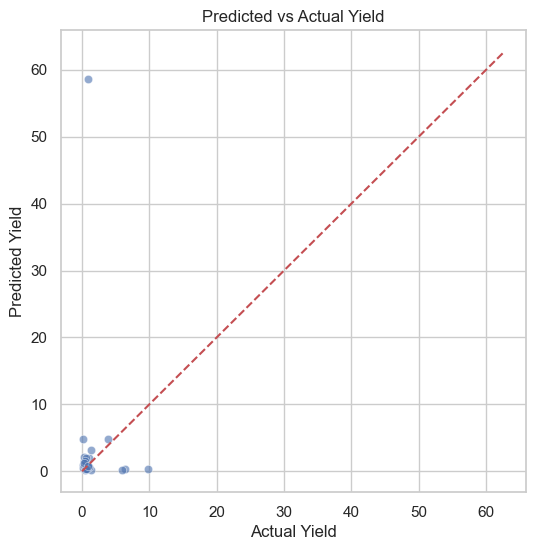

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from numpy import sqrt

# Baseline: group-mean (Crop-State-Season) fallback
group_means = df.groupby(['Crop','State','Season'])['Yield'].mean().reset_index().rename(columns={'Yield':'group_mean_yield'})
X_test_with = X_test.merge(group_means, on=['Crop','State','Season'], how='left')
crop_mean = df.groupby('Crop')['Yield'].mean().reset_index().rename(columns={'Yield':'crop_mean_yield'})
X_test_with = X_test_with.merge(crop_mean, on='Crop', how='left')
global_mean = df['Yield'].mean()
X_test_with['baseline_pred'] = X_test_with['group_mean_yield'].fillna(X_test_with['crop_mean_yield']).fillna(global_mean)

# Compute metrics
baseline_mae = mean_absolute_error(y_test, X_test_with['baseline_pred'])
baseline_rmse = sqrt(mean_squared_error(y_test, X_test_with['baseline_pred']))  # fixed
baseline_r2 = r2_score(y_test, X_test_with['baseline_pred'])

display(Markdown("### Baseline (group-mean) evaluation"))
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline R2: {baseline_r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=X_test_with['baseline_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.show()


In [13]:
def optimize_fert_pest(pipeline, farm_profile, fert_bounds=None, pest_bounds=None, n_grid=21, cost_lambda=0.0, top_k=5):
    """
    Grid-search fertilizer & pesticide combos near farmer's current values.
    - pipeline: trained pipeline (preprocessor + model)
    - farm_profile: dict with keys = FEATURES
    - fert_bounds/pest_bounds: (min, max) numeric ranges. If None, +/-50% around current.
    - n_grid: steps per dimension
    - cost_lambda: penalty weight for changing fertilizer/pesticide (relative change)
    - top_k: how many top combos to return
    """
    profile = {k: farm_profile.get(k, None) for k in FEATURES}
    # ensure numeric defaults
    curr_fert = float(profile.get('Fertilizer') if profile.get('Fertilizer') is not None and not math.isnan(profile.get('Fertilizer')) else 0.0)
    curr_pest = float(profile.get('Pesticide') if profile.get('Pesticide') is not None and not math.isnan(profile.get('Pesticide')) else 0.0)
    eps = 1e-8

    if fert_bounds is None:
        low = max(0.0, curr_fert * 0.5)
        high = max(curr_fert * 1.5, curr_fert + 1.0)
        fert_bounds = (low, high)
    if pest_bounds is None:
        low = max(0.0, curr_pest * 0.5)
        high = max(curr_pest * 1.5, curr_pest + 0.1)
        pest_bounds = (low, high)

    fert_grid = np.linspace(fert_bounds[0], fert_bounds[1], n_grid)
    pest_grid = np.linspace(pest_bounds[0], pest_bounds[1], n_grid)

    rows = []
    for f, p in product(fert_grid, pest_grid):
        row = profile.copy()
        row['Fertilizer'] = f
        row['Pesticide'] = p
        rows.append(row)
    cand_df = pd.DataFrame(rows)

    # Predict
    preds = pipeline.predict(cand_df)
    rel_fert_change = np.abs((cand_df['Fertilizer'] - curr_fert) / (curr_fert + eps))
    rel_pest_change = np.abs((cand_df['Pesticide'] - curr_pest) / (curr_pest + eps))
    penalty = cost_lambda * (rel_fert_change + rel_pest_change)
    objective = preds - penalty

    cand_df = cand_df.copy()
    cand_df['predicted_yield'] = preds
    cand_df['objective'] = objective
    cand_df['fert_change_pct'] = rel_fert_change
    cand_df['pest_change_pct'] = rel_pest_change

    top = cand_df.sort_values(by='objective', ascending=False).head(top_k)
    baseline_row = profile.copy()
    baseline_row['predicted_yield'] = pipeline.predict(pd.DataFrame([profile]))[0]

    return {
        'top_recommendations': top.reset_index(drop=True),
        'baseline_prediction': baseline_row
    }


### Model evaluation on test set

Model MAE: 0.2685
Model RMSE: 0.5803
Model R2: 0.9944


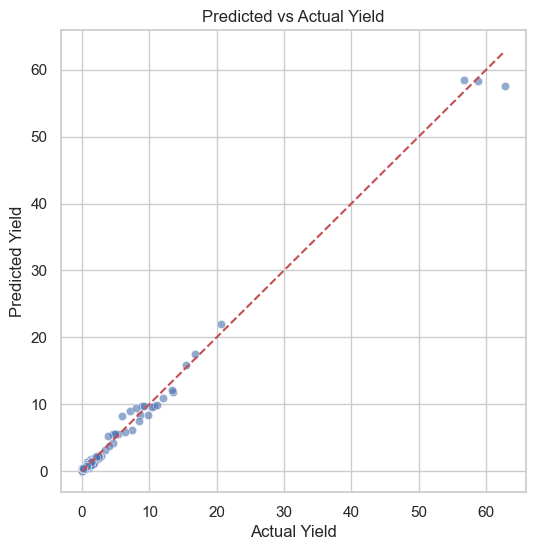

In [14]:
# === A: compute y_pred on X_test and show model metrics ===
import joblib
if 'model_pipeline' not in globals():
    model_pipeline = joblib.load(MODEL_SAVE_PATH)

y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

display(Markdown("### Model evaluation on test set"))
print(f"Model MAE: {mae:.4f}")
print(f"Model RMSE: {rmse:.4f}")
print(f"Model R2: {r2:.4f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.show()


In [15]:
# === B: helper to build full input row and predict ===
def build_input_row(area, fertilizer, pesticide, rainfall, crop='Rice', year=None, season='Kharif', state='Odisha', extra=None):
    if year is None:
        year = int(pd.Timestamp.now().year) + 1
    row = {c: np.nan for c in FEATURES}
    row.update({
        'Crop': str(crop),
        'Crop_Year': int(year),
        'Season': str(season),
        'State': str(state),
        'Area': float(area),
        'Annual_Rainfall': float(rainfall),
        'Fertilizer': float(fertilizer),
        'Pesticide': float(pesticide),
    })
    try:
        g = agg[(agg['Crop']==row['Crop']) & (agg['State']==row['State']) & (agg['Season']==row['Season'])]
        if not g.empty:
            row['group_avg_yield'] = float(g['group_avg_yield'].iloc[0])
            row['group_avg_fertilizer'] = float(g['group_avg_fertilizer'].iloc[0])
            row['group_avg_pesticide'] = float(g['group_avg_pesticide'].iloc[0])
            row['group_avg_rainfall'] = float(g['group_avg_rainfall'].iloc[0])
    except Exception:
        pass
    if isinstance(extra, dict):
        for k,v in extra.items():
            if k in row:
                row[k] = v
    return pd.DataFrame([row])

def predict_from_inputs(area, fertilizer, pesticide, rainfall, crop='Rice', year=None, season='Kharif', state='Odisha', extra=None, show_preprocessed=False):
    global model_pipeline
    if 'model_pipeline' not in globals():
        model_pipeline = joblib.load(MODEL_SAVE_PATH)
    df_in = build_input_row(area, fertilizer, pesticide, rainfall, crop, year, season, state, extra)
    if show_preprocessed:
        try:
            prep = model_pipeline.named_steps['preprocessor'].transform(df_in)
            print("DEBUG preprocessed vector (first 20):", np.round(prep[0][:20],4))
        except Exception as e:
            print("Cannot show preprocessed vector:", e)
    pred = model_pipeline.predict(df_in)[0]
    return pred


In [16]:
# === C: Sensitivity check ===
tests = [
    {'area':1.0,  'fert':50,  'pest':2,  'rain':600},
    {'area':5.0,  'fert':150, 'pest':5,  'rain':900},
    {'area':10.0, 'fert':250, 'pest':10, 'rain':1200},
]

for t in tests:
    p = predict_from_inputs(t['area'], t['fert'], t['pest'], t['rain'], crop='Rice', year=2026, season='Kharif', state='Odisha', show_preprocessed=True)
    print(f"Input {t} => Predicted Yield: {p:.4f}\n")


DEBUG preprocessed vector (first 20): [ 1.4393 -0.2494 -2.766  -0.2471 -0.2406  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.    ]
Input {'area': 1.0, 'fert': 50, 'pest': 2, 'rain': 600} => Predicted Yield: 9.4117

DEBUG preprocessed vector (first 20): [ 1.4393 -0.2494 -1.8866 -0.247  -0.2406  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.    ]
Input {'area': 5.0, 'fert': 150, 'pest': 5, 'rain': 900} => Predicted Yield: 7.9466

DEBUG preprocessed vector (first 20): [ 1.4393 -0.2494 -1.0072 -0.247  -0.2406  0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.    ]
Input {'area': 10.0, 'fert': 250, 'pest': 10, 'rain': 1200} => Predicted Yield: 7.1331



In [17]:
# === D: Diagnostics ===
a = build_input_row(1.0,50,2,600,'Rice',2026).iloc[:1]
b = build_input_row(10.0,250,10,1200,'Rice',2026).iloc[:1]
prep = model_pipeline.named_steps['preprocessor'].transform
Xp_a = prep(a)
Xp_b = prep(b)
diff_sum = float(np.sum(np.abs(Xp_a - Xp_b)))
print("Sum absolute difference of preprocessed vectors:", diff_sum)
if diff_sum == 0:
    print("Vectors identical -> check that numeric_features include these columns and df_in has numbers (not NaN).")
# Feature importance
try:
    booster = model_pipeline.named_steps['model'].get_booster()
    fmap = booster.get_score(importance_type='weight')
    items = sorted(fmap.items(), key=lambda x: -x[1])[:15]
    print("Top feature importances (name:weight):")
    for k,v in items:
        print(k, ":", v)
except Exception as e:
    print("Could not get feature importances:", e)


Sum absolute difference of preprocessed vectors: 1.7588854647008294
Could not get feature importances: 'KerasRegressor' object has no attribute 'get_booster'


In [18]:
%pip install google-generativeai

  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl (434 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.


In [19]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [20]:
            # --- Required imports ---
            import numpy as np
            import pandas as pd
            import math
            import requests
            from datetime import date as dt_date
            from IPython.display import display, Markdown, clear_output
            import ipywidgets as widgets
            import google.generativeai as genai
            import os
            from dotenv import load_dotenv

            # Load variables from the .env file into the environment
            load_dotenv()

            # --- Assume df, predict_from_inputs, optimize_fert_pest, and model_pipeline are defined above this script ---
            # For example:
            # df = pd.read_csv('your_data.csv')
            # def predict_from_inputs(...): ...
            # def optimize_fert_pest(...): ...
            # model_pipeline = ...


            # --- Create group averages table ---
            agg = df.groupby(['Crop', 'State', 'Season']).agg(
                group_avg_yield=('Yield', 'mean'),
                group_avg_fertilizer=('Fertilizer', 'mean'),
                group_avg_pesticide=('Pesticide', 'mean'),
                group_avg_rainfall=('Annual_Rainfall', 'mean')
            ).reset_index()

            # --- Widget options ---
            crop_options = sorted(df['Crop'].unique())
            state_options = sorted(df['State'].unique())
            season_options = sorted(df['Season'].unique())

            # --- Widgets ---
            w_crop = widgets.Dropdown(options=crop_options, description='Crop:')
            w_state = widgets.Dropdown(options=state_options, description='State:')
            w_season = widgets.Dropdown(options=season_options, description='Season:')
            w_year = widgets.IntText(
                value=int(df['Crop_Year'].median() if df['Crop_Year'].notnull().any() else dt_date.today().year),
                description='Year:'
            )
            w_area = widgets.FloatText(value=float(df['Area'].median()), description='Area:')
            w_rain = widgets.FloatText(value=float(df['Annual_Rainfall'].median()), description='Rainfall (mm):')
            w_fert = widgets.FloatText(value=float(df['Fertilizer'].median(skipna=True)), description='Fertilizer:')
            w_pest = widgets.FloatText(value=float(df['Pesticide'].median(skipna=True)), description='Pesticide:')
            w_grid = widgets.IntSlider(value=15, min=5, max=41, step=2, description='Grid size:')
            w_cost = widgets.FloatSlider(value=0.05, min=0.0, max=1.0, step=0.01, description='Cost λ:')
            w_topk = widgets.IntSlider(value=5, min=1, max=20, step=1, description='Top K:')

            w_fetch = widgets.Button(description="Fetch real-time rainfall", button_style='info')
            run_button = widgets.Button(description="Get Recommendations", button_style='success')
            out = widgets.Output()

            # --- Helper Functions ---

            # <<< FIX 1: RESTORED THE FULL RAINFALL API FETCHING LOGIC >>>
            def fetch_rainfall_from_api(state: str, year: int):
                url = "http://127.0.0.1:8000/rainfall"
                try:
                    resp = requests.get(url, params={"state": state, "year": int(year)}, timeout=8)
                    resp.raise_for_status()
                    data = resp.json()
                except Exception:
                    try:
                        resp = requests.get(url, timeout=8)
                        resp.raise_for_status()
                        data = resp.json()
                    except Exception:
                        return np.nan

                for key in ("total_rainfall_mm", "rainfall_mm", "total", "total_precipitation", "precipitation_sum"):
                    if key in data:
                        return float(data[key])
                if "daily" in data and "precipitation_sum" in data["daily"]:
                    return float(sum(data["daily"]["precipitation_sum"]))
                for v in data.values():
                    if isinstance(v, (int, float)):
                        return float(v)
                return np.nan

            # <<< FIX 2: RESTORED THE FULL GEMINI SUGGESTIONS LOGIC >>>
            def get_llm_suggestions(api_key: str, predicted_yield: float, farmer_profile: dict):
                """
                Generates agricultural suggestions using the Gemini API.
                This function MUST return a plain string.
                """
                try:
                    genai.configure(api_key=api_key)
                    model = genai.GenerativeModel('gemini-1.5-flash')
                    prompt = f"""
                    You are an expert agricultural advisor based in India. Your task is to provide concise, actionable advice to a farmer based on their inputs and a predicted crop yield.

                    **FARMER'S DATA:**
                    - Crop: {farmer_profile.get('Crop', 'N/A')}
                    - State: {farmer_profile.get('State', 'N/A')}
                    - Season: {farmer_profile.get('Season', 'N/A')}
                    - Annual Rainfall: {farmer_profile.get('Annual_Rainfall', 0.0):.2f} mm
                    - Fertilizer Used: {farmer_profile.get('Fertilizer', 0.0):.2f} units/ha
                    - Pesticide Used: {farmer_profile.get('Pesticide', 0.0):.2f} units/ha

                    **MODEL PREDICTION:**
                    - Predicted Yield: {predicted_yield:.2f} tons/hectare

                    **REGIONAL AVERAGES (for comparison):**
                    - Average Yield in this region for this crop: {farmer_profile.get('group_avg_yield', 'N/A')} tons/hectare
                    - Average Fertilizer used: {farmer_profile.get('group_avg_fertilizer', 'N/A')} units/ha
                    - Average Pesticide used: {farmer_profile.get('group_avg_pesticide', 'N/A')} units/ha

                    **INSTRUCTIONS:**
                    1. Analyze the farmer's data and the predicted yield.
                    2. Compare the predicted yield and the farmer's inputs (Fertilizer, Pesticide) to the regional averages.
                    3. Based on the comparison, provide 2-3 clear, simple, and actionable suggestions in a bulleted list.
                    4. If the predicted yield is lower than the average, suggest potential adjustments (e.g., "Consider adjusting fertilizer usage closer to the regional average of X," or "The rainfall in your area is lower than average; ensure consistent irrigation if possible.").
                    5. Keep the tone helpful, encouraging, and easy for a farmer to understand. Start with a brief summary sentence.
                    """
                    response = model.generate_content(prompt)
                    return response.text
                except Exception as e:
                    return f"An error occurred while generating AI suggestions: {e}"


            # --- Callbacks ---

            # <<< FIX 3: RESTORED THE FULL FETCH BUTTON CLICK LOGIC >>>
            def on_fetch_clicked(b):
                with out:
                    clear_output(wait=True)
                    display(Markdown("Fetching..."))
                    val = fetch_rainfall_from_api(w_state.value, w_year.value)
                    clear_output(wait=True) # Clear the "Fetching..." message
                    if not math.isnan(val):
                        w_rain.value = float(val)
                        display(Markdown(f"**Fetched rainfall for {w_state.value} ({w_year.value}):** {val:.1f} mm"))
                    else:
                        display(Markdown(f"**Failed to fetch rainfall for {w_state.value}.** Please check API or enter manually."))

            w_fetch.on_click(on_fetch_clicked)

            def on_run_clicked(b):
                with out:
                    try:
                        clear_output(wait=True)
                        display(Markdown("Processing..."))

                        profile = {
                            'Crop': w_crop.value, 'Crop_Year': int(w_year.value), 'Season': w_season.value,
                            'State': w_state.value, 'Area': float(w_area.value), 'Annual_Rainfall': float(w_rain.value),
                            'Fertilizer': float(w_fert.value), 'Pesticide': float(w_pest.value),
                        }

                        match = agg[(agg['Crop']==profile['Crop']) & (agg['State']==profile['State']) & (agg['Season']==profile['Season'])]
                        if not match.empty:
                            profile['group_avg_yield'] = match['group_avg_yield'].iloc[0]
                            profile['group_avg_fertilizer'] = match['group_avg_fertilizer'].iloc[0]
                            profile['group_avg_pesticide'] = match['group_avg_pesticide'].iloc[0]
                            profile['group_avg_rainfall'] = match['group_avg_rainfall'].iloc[0]
                        
                        clear_output(wait=True) # Clear the "Processing..." message
                        display(Markdown("### Farmer Profile"))
                        display(pd.DataFrame([profile]))

                        scale_factor_area = 10000
                        scale_factor_fert = 1000
                        scale_factor_pest = 1000

                        scaled_profile = profile.copy()
                        scaled_profile['Area'] *= scale_factor_area
                        scaled_profile['Fertilizer'] *= scale_factor_fert
                        scaled_profile['Pesticide'] *= scale_factor_pest
                        
                        y_pred = predict_from_inputs(
                            area=scaled_profile['Area'], fertilizer=scaled_profile['Fertilizer'],
                            pesticide=scaled_profile['Pesticide'], rainfall=scaled_profile['Annual_Rainfall'],
                            crop=scaled_profile['Crop'], year=scaled_profile['Crop_Year'],
                            season=scaled_profile['Season'], state=scaled_profile['State']
                        )
                        display(Markdown("### Predicted Yield"))
                        display(pd.DataFrame([{'Predicted Yield': y_pred}]))

                        recs = optimize_fert_pest(
                            model_pipeline, scaled_profile, n_grid=w_grid.value,
                            cost_lambda=w_cost.value, top_k=w_topk.value
                        )
                        display(Markdown("### Top Numerical Recommendations"))
                        display(recs['top_recommendations'][['Fertilizer','Pesticide','predicted_yield']])
                        
                        display(Markdown("--- \n ### AI Advisor's Summary"))
                        GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
                        
                        if not GEMINI_API_KEY:
                            display(Markdown("**Warning:** `GEMINI_API_KEY` not found. Please create a `.env` file and add your key to it."))
                        else:
                            llm_advice = get_llm_suggestions(
                                api_key=GEMINI_API_KEY,
                                predicted_yield=y_pred,
                                farmer_profile=profile 
                            )
                            display(Markdown(llm_advice))

                    except Exception as e:
                        clear_output(wait=True)
                        print("An error occurred in the main process:", e)

            run_button.on_click(on_run_clicked)

            # --- ESSENTIAL: Show the UI ---
            # This part is crucial and must be at the end to render the widgets.
            display(widgets.VBox([
                widgets.HBox([w_crop, w_state, w_season, w_year]),
                widgets.HBox([w_area, w_rain, w_fert, w_pest]),
                widgets.HBox([w_grid, w_cost, w_topk]),
                widgets.HBox([w_fetch, run_button]),
                out
            ]))

In [ ]:
# 1. Check target distribution
print(y_train.describe())
print(y_train.value_counts().head(10))

# 2. See model training score
from sklearn.metrics import r2_score
train_preds = model_pipeline.predict(X_train)
print("Train R2 score:", r2_score(y_train, train_preds))

# 3. Check feature importances
model = model_pipeline.named_steps['model']
print(model.feature_importances_)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
test_preds = model_pipeline.predict(X_test)
print("Test R2:", r2_score(y_test, test_preds))
print("Test MAE:", mean_absolute_error(y_test, test_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, test_preds)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.show()


In [ ]:
import pandas as pd

# Get the same feature columns the model expects
expected_cols = X_train.columns

# Pick a base row from training data
base_row = X_train.iloc[0].copy()

sample_inputs = [
    [1.0, 50, 2, 600],
    [5.0, 150, 5, 900],
    [10.0, 250, 10, 1200]
]

for i, s in enumerate(sample_inputs, 1):
    row = base_row.copy()
    row['Area'] = s[0]
    row['Fertilizer'] = s[1]
    row['Pesticide'] = s[2]
    row['Annual_Rainfall'] = s[3]
    
    df_input = pd.DataFrame([row])
    pred = model_pipeline.predict(df_input)
    print(f"Sample {i}: {s} => Predicted Yield: {pred[0]:.2f}")


In [ ]:
# Example automatic run using a random test sample (useful to verify everything works)
sample = X_test.sample(1, random_state=42).iloc[0].to_dict()
print("Sample farm profile (auto):")
display(pd.DataFrame([sample]))
res_auto = optimize_fert_pest(model_pipeline, sample, n_grid=15, cost_lambda=0.05, top_k=5)
print("Baseline predicted yield:", res_auto['baseline_prediction']['predicted_yield'])
display(res_auto['top_recommendations'][['Fertilizer','Pesticide','predicted_yield']])
# Save example recommendations for inspection
res_auto['top_recommendations'].to_csv(RECS_SAVE_PATH.replace('.csv','_auto.csv'), index=False)
print("Saved auto recommendations to:", RECS_SAVE_PATH.replace('.csv','_auto.csv'))


In [ ]:
display(Markdown("## Notes & Next steps"))
display(Markdown("""
- This notebook uses a **predictive model** to recommend fertilizer/pesticide. It **does not** prove causality.
- Recommended next steps:
  1. Validate recommendations with small field trials (A/B testing).
  2. Add soil properties (pH, NPK) if available — they strongly influence fertilizer effects.
  3. Consider Bayesian optimization (optuna / scikit-optimize) to replace grid search for speed.
  4. If you want, enable XGBoost (`MODEL_CHOICE='xgb'`) for possibly better performance (install xgboost).
- If any widget values produce NaNs or errors, ensure your dataset has reasonable medians (we used medians to initialize widgets).
"""))
